In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '../')
import read_stuff as read
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_2172698/698028492.py:19: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
from tools.validation import r2_analysis
class OptimMLR_2D(torch.nn.Module):
    def __init__(self):
        super(OptimMLR_2D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize=[30,30]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(2,106)
        
    def forward(self,X):
        brchindex = [0,30,60]
        X_lw, X_sw = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestlw = self.dense1(X_lw)
        bestsw = self.dense2(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [4]:
class OptimMLR_uv_2D(torch.nn.Module):
    def __init__(self):
        super(OptimMLR_uv_2D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [30,30,52,60]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(4,106)
        
    def forward(self,X):
        brchindex = [0,30,60,60+52,60+52+60]
        X_lw, X_sw, X_u, X_w = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestlw = self.dense1(X_lw)
        bestsw = self.dense2(X_sw)
        bestu = self.dense3(X_u)
        bestw = self.dense4(X_w)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestlw,bestsw,bestu,bestw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [5]:
class OptimMLR_all_2D(torch.nn.Module):
    def __init__(self):
        super(OptimMLR_all_2D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [26*2,18*2,48+12,14*2,9*2,6*3,30,30]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        self.dense8 = torch.nn.Linear(brchsize[7], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(8,176)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,26*2,18*2,48+12,14*2,9*2,6*3,30,30]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_rh, X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]],X[:,brchindex[7]:brchindex[8]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        bestrh = self.dense5(X_rh)
        besthdia = self.dense6(X_hdia)
        bestlw = self.dense7(X_lw)
        bestsw = self.dense8(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,bestrh,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [6]:
class OptimMLR_all_2D(torch.nn.Module):
    def __init__(self):
        super(OptimMLR_all_2D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [26*2,18*2,48+12,14*2,6*3,30,30]#9*2,6*3,30,30]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(7,106)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,26*2,18*2,48+12,14*2,6*3,30,30]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        besthdia = self.dense5(X_hdia)
        bestlw = self.dense6(X_lw)
        bestsw = self.dense7(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

## Read stuff

In [4]:
import importlib
importlib.reload(read)

<module 'read_stuff' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/analysis/../read_stuff.py'>

In [7]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading input and outpus                    
└──────────────────────────────────────────────────────────────────────────"""
Xtrain,Xvalid,Xtest,yall,yall_orig = read.train_optimizedMLR(folderpath,folderpath2,'rh','rh').read_Xy(num=33)
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading PC structures for custom loss                       
└──────────────────────────────────────────────────────────────────────────"""
pcastore = read.train_optimizedMLR(folderpath,folderpath2,'rh','rh').pcastore
#wcomps = [26,18,48,14]
wcomps = [26*2,18*2,48+12,14*2]
upcs,vpcs,wpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['w'].components_[:wcomps[2]],pcastore['theta'].components_[:wcomps[3]]
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading y truth for custom loss                      
└──────────────────────────────────────────────────────────────────────────"""
yTRUTH = read.train_optimizedMLR(folderpath,folderpath2,'rh','rh').y_truth(divider=divider,lti=24,num=33)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [8]:
import glob
def output_processed(Xtrain=None,Xvalid=None,Xtest=None,yall=None,folderpath=None,folderpath2=None,splitnum=None):
    """──────────────────────────────────────────────────────────────────────────┐
    │ Which split will we be testing                     
    └──────────────────────────────────────────────────────────────────────────"""
    splitnum = splitnum
    """──────────────────────────────────────────────────────────────────────────┐
    │ Remove zero values                    
    └──────────────────────────────────────────────────────────────────────────"""
    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2,'rh').delete_padding(Xtrain[splitnum]['lwswdtthuvwqv'],yall[splitnum][23][0])
    X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2,'rh').delete_padding(Xvalid[splitnum]['lwswdtthuvwqv'],yall[splitnum][23][1])
    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2,'rh').delete_padding(Xtest[splitnum]['lwswdtthuvwqv'],yall[splitnum][23][2])
    
    calc_device = 'cpu'
    ###################################################################################
    # Convert numpy arrays into tensors
    ###################################################################################
    train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
    train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
    val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
    val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
    test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
    test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
    train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
    val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
    test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
    
    modelpaths = sorted(glob.glob('../tmp/torch_try/1108/'+str(splitnum)+'/models*'))
    model = [torch.load(obj) for obj in modelpaths]
    
    return {'train':train_Xtensor,'val':val_Xtensor,'test':test_Xtensor},{'train':train_ytensor,'val':val_ytensor,'test':test_ytensor},{'train':train_data,'val':val_data,'test':test_data},model

In [9]:
import analysis
lti=24
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/'
model_c3 = read_and_proc.depickle(folderpath+'/output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/FFWmodels_cross7_0_33')
new_feature_c3 = read_and_proc.depickle(folderpath+'/output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/newfeature_cross7_0_33')
reducedX_c3 = read_and_proc.depickle(folderpath+'/output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/reducedX_cross7_0_33')
haiyanmodelsDICT = {'model':model_c3,'newfeature':new_feature_c3,'reducedX':reducedX_c3}
del model_c3,new_feature_c3,reducedX_c3
gc.collect()

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
Xtest_orig,Xtrain_orig,Xvalid_orig = [],[],[]

for i in tqdm(range(33)):
    temp1,temp2,temp3,temp4 = analysis.real_random(i,3,folderpath)
    Xtest_orig.append(temp1)
    Xtrain_orig.append(temp2)
    Xvalid_orig.append(temp3)
    
from tools.validation import r2_analysis
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
dict1 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g')
haiyan_data = read_and_proc.depickle(folderpath+'pca/flatvar'+'_'+'dict2_g')

orig_tests = r2_analysis._get_r2(dict1,haiyan_data,[26,18,48,14],24,haiyanmodelsDICT['model'],haiyanmodelsDICT['reducedX'],None,'Haiyan_axisym')._get_testX(Xtest_orig,yall_orig,[121,122,123,124],haiyanmodelsDICT['newfeature'])

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  0%|          | 0/33 [00:00<?, ?it/s]

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator IncrementalPCA from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  0%|          | 0/33 [00:00<?, ?it/s]

In [10]:
importlib.reload(r2_analysis)

NameError: name 'importlib' is not defined

In [17]:
orig_validY = r2_analysis._get_r2(dict1,haiyan_data,[26,18,48,14],24,haiyanmodelsDICT['model'],haiyanmodelsDICT['reducedX'],None,'Haiyan_axisym')._get_validX(Xvalid_orig,yall_orig,[121,122,123,124],haiyanmodelsDICT['newfeature'])
orig_trainY = r2_analysis._get_r2(dict1,haiyan_data,[26,18,48,14],24,haiyanmodelsDICT['model'],haiyanmodelsDICT['reducedX'],None,'Haiyan_axisym')._get_trainX(Xtrain_orig,yall_orig,[121,122,123,124],haiyanmodelsDICT['newfeature'])
orig_testY = r2_analysis._get_r2(dict1,haiyan_data,[26,18,48,14],24,haiyanmodelsDICT['model'],haiyanmodelsDICT['reducedX'],None,'Haiyan_axisym')._get_testX(Xtest_orig,yall_orig,[121,122,123,124],haiyanmodelsDICT['newfeature'])

  0%|          | 0/33 [00:00<?, ?it/s]

## Analysis

### R2 analyais

In [18]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var

def store_r2(pcastore=None,yTRUTH=None,model=None,splitnum=30,Xtensor=None,category='test',origYs=None):
    folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
    folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
    #Xtensor,ytensor,data,models = output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,splitnum)
    if category=='test':
        orig_tests = origYs[2]
    elif category=='valid':
        orig_tests =  origYs[1]
    elif category=='train':
        orig_tests =  origYs[0]
    orig_th = np.dot(haiyanmodelsDICT['model'][splitnum][0].predict(orig_tests[splitnum][1])[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    orig_w = np.dot(haiyanmodelsDICT['model'][splitnum][0].predict(orig_tests[splitnum][1])[:,26+18:26+18+48],pcastore['w'].components_[:48])
    orig_v = np.dot(haiyanmodelsDICT['model'][splitnum][0].predict(orig_tests[splitnum][1])[:,26:26+18],pcastore['v'].components_[:18])
    orig_u = np.dot(haiyanmodelsDICT['model'][splitnum][0].predict(orig_tests[splitnum][1])[:,:26],pcastore['u'].components_[:26])
    origs = [orig_u,orig_v,orig_w,orig_th]
    del orig_u, orig_v, orig_w, orig_th
    gc.collect()

    bbbbbb_th = np.dot(model[0](Xtensor[category]).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    bbbbbb_w = np.dot(model[0](Xtensor[category]).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    bbbbbb_v = np.dot(model[0](Xtensor[category]).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    bbbbbb_u = np.dot(model[0](Xtensor[category]).detach().numpy()[:,:26],pcastore['u'].components_[:26])
    
    uper = [r2_score(yTRUTH[category][splitnum]['du'],origs[0]),r2_score(yTRUTH[category][splitnum]['du'],bbbbbb_u)]
    vper = [r2_score(yTRUTH[category][splitnum]['dv'],origs[1]),r2_score(yTRUTH[category][splitnum]['dv'],bbbbbb_v)]
    wper = [r2_score(yTRUTH[category][splitnum]['dw'],origs[2]),r2_score(yTRUTH[category][splitnum]['dw'],bbbbbb_w)]
    thper = [r2_score(yTRUTH[category][splitnum]['dth'],origs[3]),r2_score(yTRUTH[category][splitnum]['dth'],bbbbbb_th)]
    return {'u':uper[0],'v':vper[0],'w':wper[0],'theta':thper[0]},{'u':uper[1],'v':vper[1],'w':wper[1],'theta':thper[1]}

import pandas as pd
def __store_r2(TYPE='test',yorigs=None):
    storemodels = []
    storeorig = []
    allmodels = []
    for split in tqdm(range(33)):
        folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
        folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
        origr2,newr2 = [],[]
        Xtensor,ytensor,data,models = output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,split)
        xgmodl = []
        for i in range(len(models)):
            a,b = store_r2(pcastore=pcastore,yTRUTH=yTRUTH,model=models[i],splitnum=split,Xtensor=Xtensor,category=TYPE,origYs=yorigs)
            origr2.append(a)
            newr2.append(b)
            xgmodl.append(models[i])
        X = pd.DataFrame.from_dict({'u':[obj['u'] for obj in newr2],'v':[obj['v'] for obj in newr2],'w':[obj['w'] for obj in newr2],'theta':[obj['theta'] for obj in newr2]})
        storemodels.append(X)
        storeorig.append(origr2)
        allmodels.append(xgmodl)
        
    allpd = pd.concat(objs=(iDF for iDF in storemodels),axis=0, join='inner').reset_index()
    allpds = allpd.drop(columns=['index'])
    storeMLR = [storeorigobj[0] for storeorigobj in storeorig]
    MLRX = pd.DataFrame.from_dict({'u':[obj['u'] for obj in storeMLR],'v':[obj['v'] for obj in storeMLR],'w':[obj['w'] for obj in storeMLR],'theta':[obj['theta'] for obj in storeMLR]})
    allpd_out = pd.concat(objs=(allpds.drop(columns=['w']),MLRX.drop(columns=['w'])),axis=0,join='inner').reset_index()
    allpd_outs = allpd_out.drop(columns=['index'])
    allpds_copy = allpds.copy()
    allpds_copy['mean'] = (allpds_copy['u']+allpds_copy['v']+allpds_copy['theta'])/3
    allpds_copy.sort_values(by=['mean'], ascending=False)
    return storemodels,storeorig,allmodels,{'v2':allpds_copy,'v1_mlr':MLRX,'v1_torch':allpds}

In [19]:
train_storemls,train_storeorig,train_allmdls,train_allpds = __store_r2('train',[orig_trainY,orig_validY,orig_testY])
test_storemls,test_storeorig,test_allmdls,test_allpds = __store_r2('test',[orig_trainY,orig_validY,orig_testY])

  0%|          | 0/33 [00:00<?, ?it/s]

/tmp/ipykernel_2172698/1774273896.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136119739/work/torch/csrc/utils/tensor_new.cpp:201.)
  train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)


  0%|          | 0/33 [00:00<?, ?it/s]

/tmp/ipykernel_3108678/3154569310.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


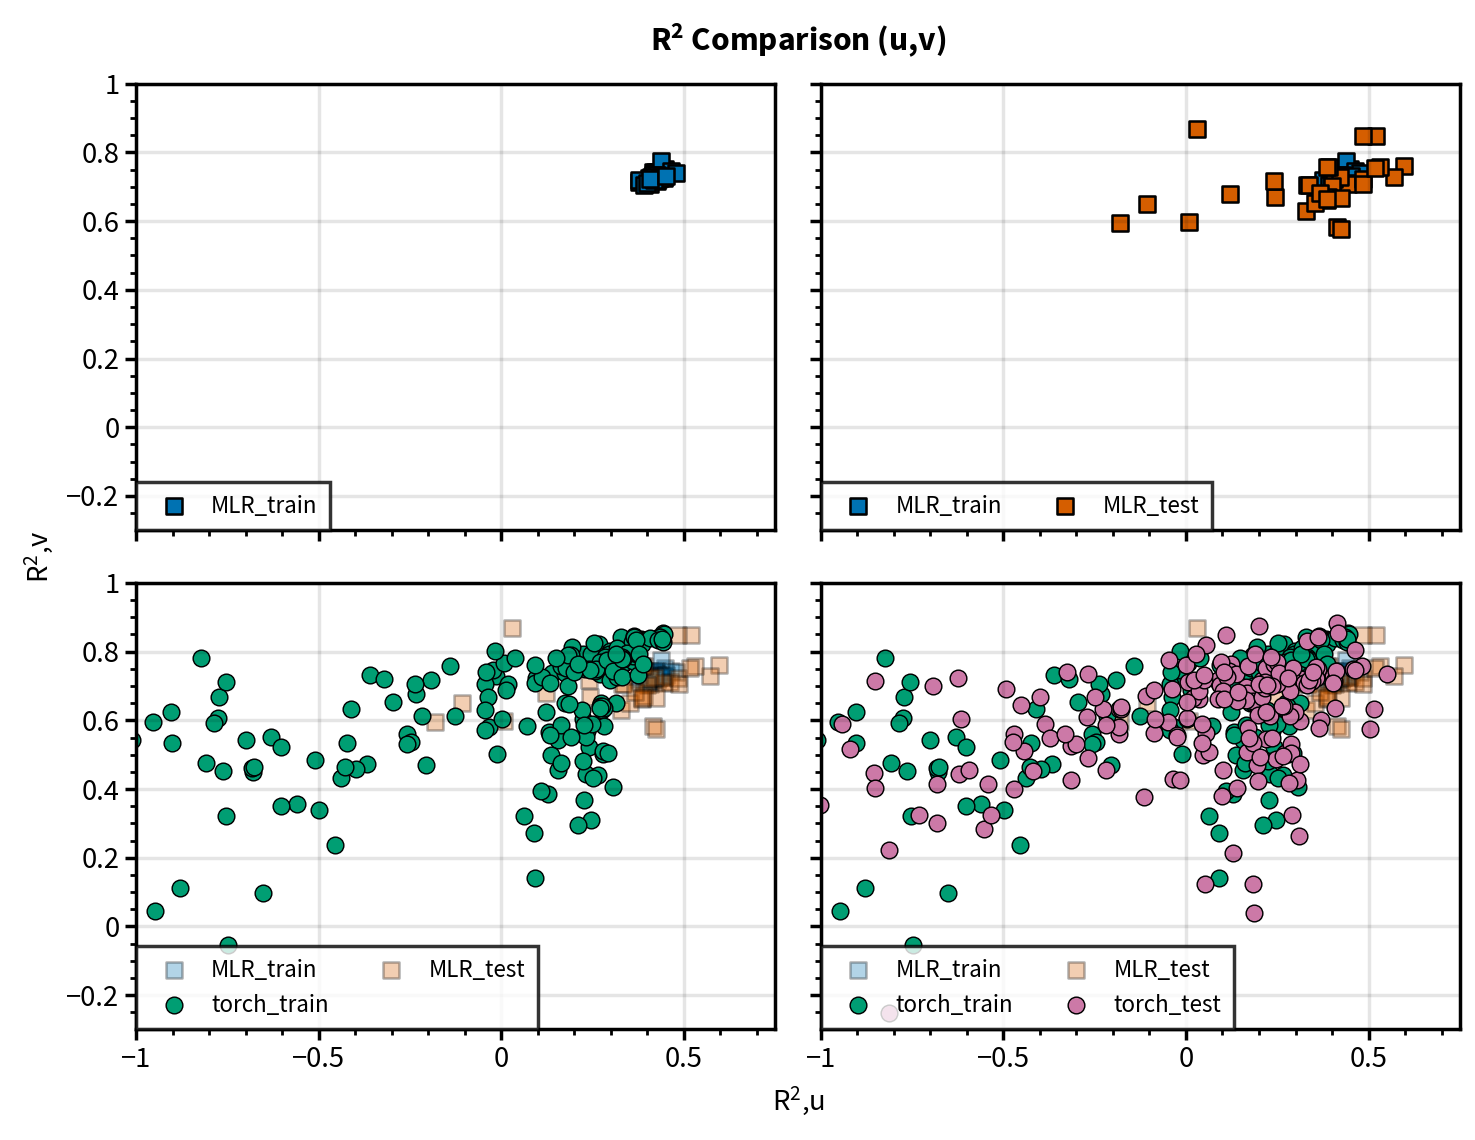

In [60]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

indx=1
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=3.195,refaspect=1.431)
#axs[0].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
#axs[0].scatter(test_allpds['v1_torch']['u'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
axs[0].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[0].legend(loc='ll',prop={'size':9})
axs[1].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[1].scatter(test_allpds['v1_mlr']['u'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test')
axs[1].legend(loc='ll',prop={'size':9})
axs[2].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[2].scatter(test_allpds['v1_mlr']['u'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[2].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[2].legend(loc='ll',ncols=2,prop={'size':9})
axs[3].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[3].scatter(test_allpds['v1_mlr']['u'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[3].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[3].scatter(test_allpds['v1_torch']['u'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_test')
axs[3].legend(loc='ll',ncols=2,prop={'size':9})
axs.format(xlim=[-1,0.75],ylim=[-0.3,1],xlabel=r'R$^{2}$,u',ylabel=r'R$^{2}$,v',suptitle=r'R$^{2}$ Comparison (u,v)')
plt.savefig('./pic/proposal/r2_uv.png',dpi=300)
plt.show()

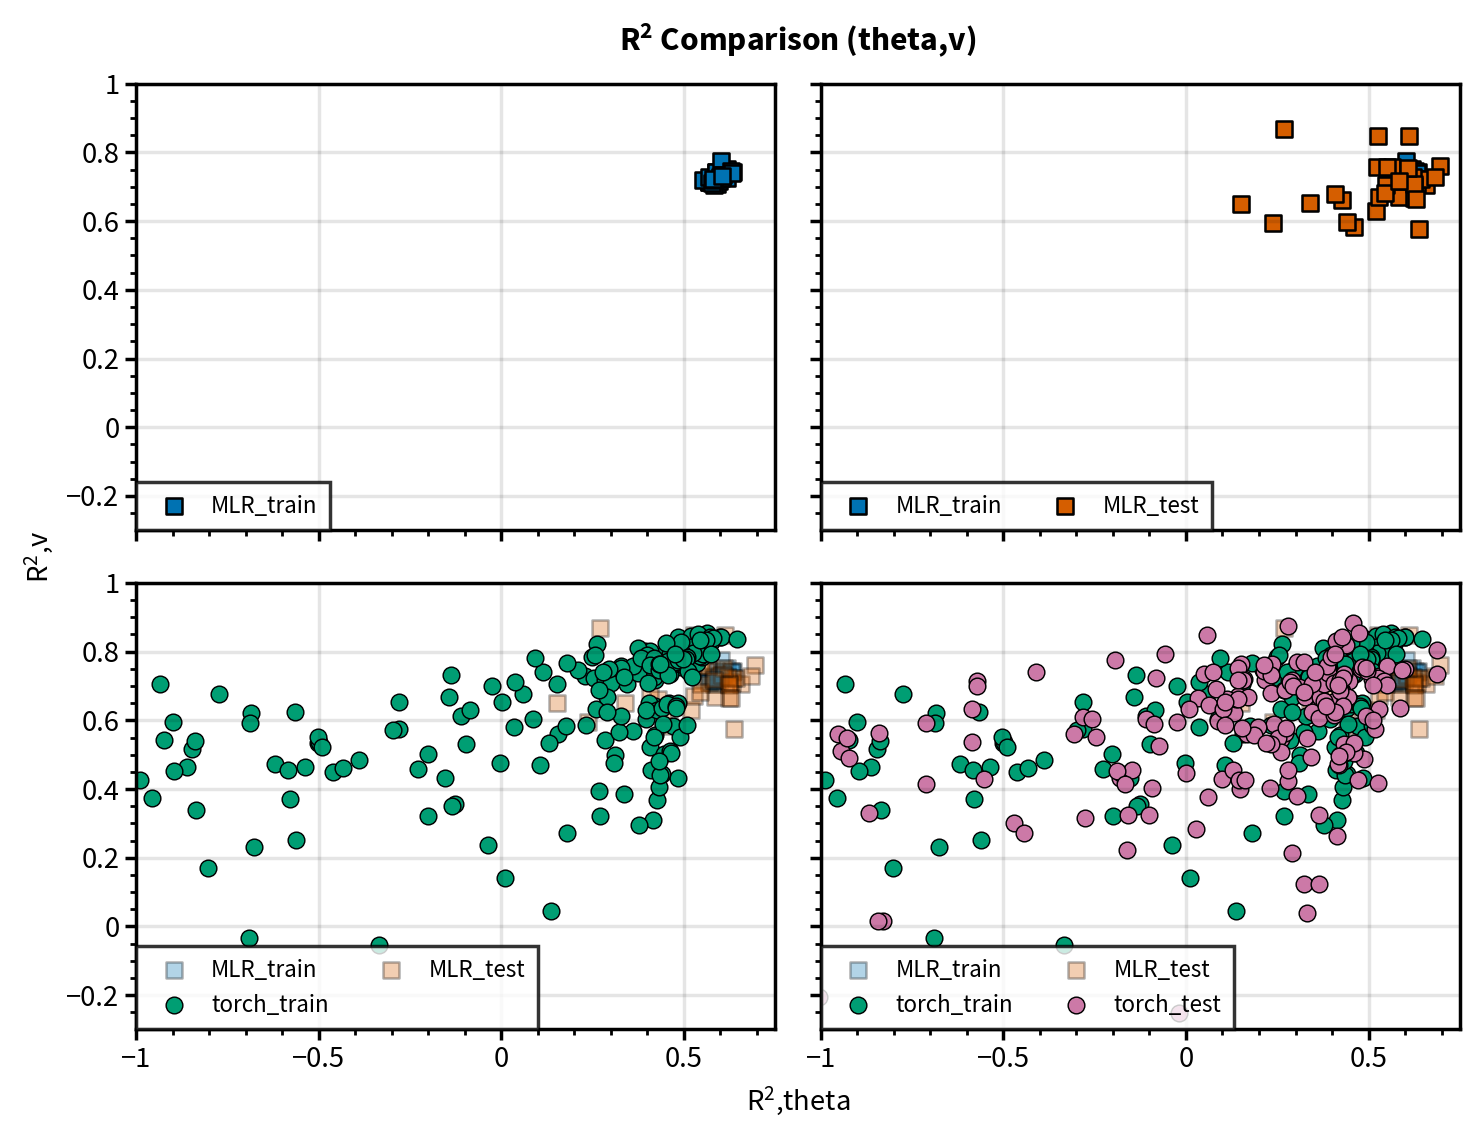

In [62]:
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=3.195,refaspect=1.431)
#axs[0].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
#axs[0].scatter(test_allpds['v1_torch']['u'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
axs[0].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[0].legend(loc='ll',prop={'size':9})
axs[1].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[1].scatter(test_allpds['v1_mlr']['theta'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test')
axs[1].legend(loc='ll',prop={'size':9})
axs[2].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[2].scatter(test_allpds['v1_mlr']['theta'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[2].scatter(train_allpds['v1_torch']['theta'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[2].legend(loc='ll',ncols=2,prop={'size':9})
axs[3].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[3].scatter(test_allpds['v1_mlr']['theta'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[3].scatter(train_allpds['v1_torch']['theta'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[3].scatter(test_allpds['v1_torch']['theta'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_test')
axs[3].legend(loc='ll',ncols=2,prop={'size':9})
axs.format(xlim=[-1,0.75],ylim=[-0.3,1],xlabel=r'R$^{2}$,theta',ylabel=r'R$^{2}$,v',suptitle=r'R$^{2}$ Comparison (theta,v)')
plt.savefig('./pic/proposal/r2_thetav.png',dpi=300)
plt.show()

##### TSNE

In [231]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
rnd_seed=8881
tsne = TSNE(n_components=2, # We'll project onto 2D plane
            random_state=rnd_seed, # We need a random seed
            perplexity = 20,
            n_iter = 10000,
            learning_rate='auto') #Let the algorithm handle the learning rate
#pca = PCA(n_components=2)
# And now get the input data in 2-component reduced form
X_plot = tsne.fit_transform(allpd_outs)
#X_plot = pca.fit_transform(allpd.drop(columns=['index']))

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [226]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, init='random',n_init=50, max_iter=300, tol=1e-04, random_state=rnd_seed)
y_km = km.fit_predict(X_plot)

/tmp/ipykernel_3246475/2925045945.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


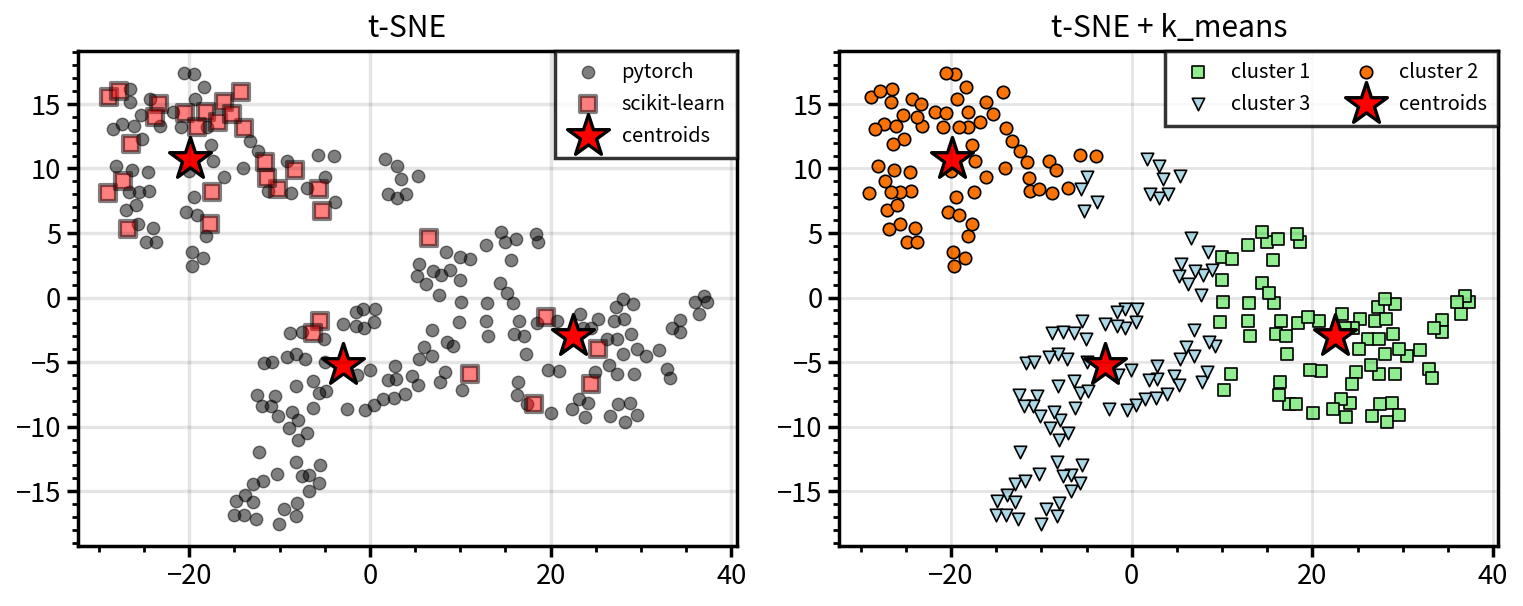

In [232]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.295,refaspect=1.331,share=False)
axs[0].scatter(X_plot[:-32,0],X_plot[:-32,1],s=20,linewidths=0.5,edgecolors='k',c='k',alpha=0.5,label='pytorch')
axs[0].scatter(X_plot[-32:,0],X_plot[-32:,1],s=30,linewidths=1.5,edgecolors='k',c='r',marker='s',alpha=0.5,label='scikit-learn')

axs[0].scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='r', edgecolor='black',
    label='centroids',linewidths=1.2)
axs[0].legend(scatterpoints=1,prop={'size':8},ncols=1)
# plot the 3 clusters
axs[1].scatter(X_plot[y_km == 0, 0], X_plot[y_km == 0, 1],s=20, c='lightgreen',marker='s', edgecolor='black',label='cluster 1')
axs[1].scatter(X_plot[y_km == 1, 0], X_plot[y_km == 1, 1],s=20, c='orange',marker='o', edgecolor='black',label='cluster 2')
axs[1].scatter(X_plot[y_km == 2, 0], X_plot[y_km == 2, 1],s=20, c='lightblue',marker='v', edgecolor='black',label='cluster 3')
# plot the centroids
axs[1].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],s=250, marker='*',c='r', edgecolor='black',label='centroids',linewidths=1.2)
axs[1].legend(scatterpoints=1,prop={'size':8},ncols=2)
axs[1].grid(lw=1)
axs[0].format(title='t-SNE')
axs[1].format(title='t-SNE + k_means')
plt.savefig('./pic/tsne_analysis.png',dpi=300)
plt.show()

In [283]:
allpd['TrueFalse0'] = [y_km[:-32] == 0][0]
allpd['TrueFalse1'] = [y_km[:-32] == 1][0]
allpd['TrueFalse2'] = [y_km[:-32] == 2][0]

In [285]:
allpd[allpd['TrueFalse0']==True][['u','v','w','theta']].mean()

u         -0.144874
v          0.615149
w       -165.931118
theta      0.010857
dtype: float64

In [284]:
allpd[allpd['TrueFalse1']==True][['u','v','w','theta']].mean()

u         0.447200
v         0.731931
w       -27.363415
theta     0.575293
dtype: float64

In [286]:
allpd[allpd['TrueFalse2']==True][['u','v','w','theta']].mean()

u         0.269698
v         0.733762
w       -43.003008
theta     0.466241
dtype: float64

In [287]:
def flatten(l):
    return [item for sublist in l for item in sublist]
allmodels_f = flatten(allmodels)
allmodels_f2 = [i for (i, v) in zip(allmodels_f, [y_km[:-32] == 2][0]) if v]#allmodels_f[[y_km[:-32] == 1][0]]

#### LW-SW

In [20]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][0]['du'],orig_u),r2_score(yTRUTH['test'][0]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][0]['dv'],orig_v),r2_score(yTRUTH['test'][0]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][0]['dw'],orig_w),r2_score(yTRUTH['test'][0]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][0]['dth'],orig_th),r2_score(yTRUTH['test'][0]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.462837147288513,0.37049650580471716
v: 0.7123054718641962,0.6305698869735039
w: 0.16834662199378614,-21.18398331267203
th: 0.6257094083437218,0.5274264968824663


#### LW-SW-u-w

In [25]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][0]['du'],orig_u),r2_score(yTRUTH['test'][0]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][0]['dv'],orig_v),r2_score(yTRUTH['test'][0]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][0]['dw'],orig_w),r2_score(yTRUTH['test'][0]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][0]['dth'],orig_th),r2_score(yTRUTH['test'][0]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.462837147288513,0.37317213719765385
v: 0.7123054718641962,0.6260220709286232
w: 0.16834662199378614,-3.843214640202749
th: 0.6257094083437218,0.5249754830105064


#### All channels

In [19]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][0]['du'],orig_u),r2_score(yTRUTH['test'][0]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][0]['dv'],orig_v),r2_score(yTRUTH['test'][0]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][0]['dw'],orig_w),r2_score(yTRUTH['test'][0]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][0]['dth'],orig_th),r2_score(yTRUTH['test'][0]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.462837147288513,0.38399995915133767
v: 0.7123054718641962,0.6298793153377171
w: 0.16834662199378614,0.23600065517076285
th: 0.6257094083437218,0.5544713369424776


#### 2*weights du,dw

In [25]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][0]['du'],orig_u),r2_score(yTRUTH['test'][0]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][0]['dv'],orig_v),r2_score(yTRUTH['test'][0]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][0]['dw'],orig_w),r2_score(yTRUTH['test'][0]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][0]['dth'],orig_th),r2_score(yTRUTH['test'][0]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.462837147288513,-0.5396018443313122
v: 0.7123054718641962,0.478279374277371
w: 0.16834662199378614,-376.3771224407094
th: 0.6257094083437218,-0.15442973940233218


#### MSE-all channels

In [44]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][0]['du'],orig_u),r2_score(yTRUTH['test'][0]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][0]['dv'],orig_v),r2_score(yTRUTH['test'][0]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][0]['dw'],orig_w),r2_score(yTRUTH['test'][0]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][0]['dth'],orig_th),r2_score(yTRUTH['test'][0]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.462837147288513,0.4023459513102743
v: 0.7123054718641962,0.7432699227031119
w: 0.16834662199378614,-88.11039406871001
th: 0.6257094083437218,0.5455026996784049


In [163]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][0]['du'],orig_u),r2_score(yTRUTH['test'][0]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][0]['dv'],orig_v),r2_score(yTRUTH['test'][0]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][0]['dw'],orig_w),r2_score(yTRUTH['test'][0]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][0]['dth'],orig_th),r2_score(yTRUTH['test'][0]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.462837147288513,0.4023459513102743
v: 0.7123054718641962,0.7432699227031119
w: 0.16834662199378614,-88.11039406871001
th: 0.6257094083437218,0.5455026996784049


In [91]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][0]['du'],orig_u),r2_score(yTRUTH['test'][0]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][0]['dv'],orig_v),r2_score(yTRUTH['test'][0]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][0]['dw'],orig_w),r2_score(yTRUTH['test'][0]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][0]['dth'],orig_th),r2_score(yTRUTH['test'][0]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.462837147288513,0.4641097732577564
v: 0.7123054718641962,0.7990391693270449
w: 0.16834662199378614,-6.641673130911564
th: 0.6257094083437218,0.5531009397498771


In [57]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][splitnum]['du'],orig_u),r2_score(yTRUTH['test'][splitnum]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][splitnum]['dv'],orig_v),r2_score(yTRUTH['test'][splitnum]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][splitnum]['dw'],orig_w),r2_score(yTRUTH['test'][splitnum]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][splitnum]['dth'],orig_th),r2_score(yTRUTH['test'][splitnum]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.33012053548779696,-1.7973700991039339
v: 0.7063807263278488,0.4061678574568761
w: 0.060563175935498315,-570.6321892806028
th: 0.6570922701941304,-1.3437784771743253


In [27]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var
uper = [r2_score(yTRUTH['test'][splitnum]['du'],orig_u),r2_score(yTRUTH['test'][splitnum]['du'],bbbbbb_u)]
vper = [r2_score(yTRUTH['test'][splitnum]['dv'],orig_v),r2_score(yTRUTH['test'][splitnum]['dv'],bbbbbb_v)]
wper = [r2_score(yTRUTH['test'][splitnum]['dw'],orig_w),r2_score(yTRUTH['test'][splitnum]['dw'],bbbbbb_w)]
thper = [r2_score(yTRUTH['test'][splitnum]['dth'],orig_th),r2_score(yTRUTH['test'][splitnum]['dth'],bbbbbb_th)]

print(f'Performance: ')
print(f'u: {uper[0]},{uper[1]}')
print(f'v: {vper[0]},{vper[1]}')
print(f'w: {wper[0]},{wper[1]}')
print(f'th: {thper[0]},{thper[1]}')

Performance: 
u: 0.42464609620631644,0.30602790521479517
v: 0.576166520419606,0.21815398971895028
w: 0.19929794188901606,-22.7797392454031
th: 0.6369012359359364,0.365927221605849


### Look at predictions

In [176]:
def give_pred(pcastore=None,model=None,splitnum=30,tensor_topred=None):
    bbbbbb_th = np.dot(model(tensor_topred).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    bbbbbb_w = np.dot(model(tensor_topred).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    bbbbbb_v = np.dot(model(tensor_topred).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    bbbbbb_u = np.dot(model(tensor_topred).detach().numpy()[:,:26],pcastore['u'].components_[:26])
    return {'u':bbbbbb_u,'v':bbbbbb_v,'w':bbbbbb_w,'theta':bbbbbb_th}

In [ ]:
give_pred(pcastore=None,model=None,splitnum=30,tensor_topred=None)

/tmp/ipykernel_440535/565967204.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


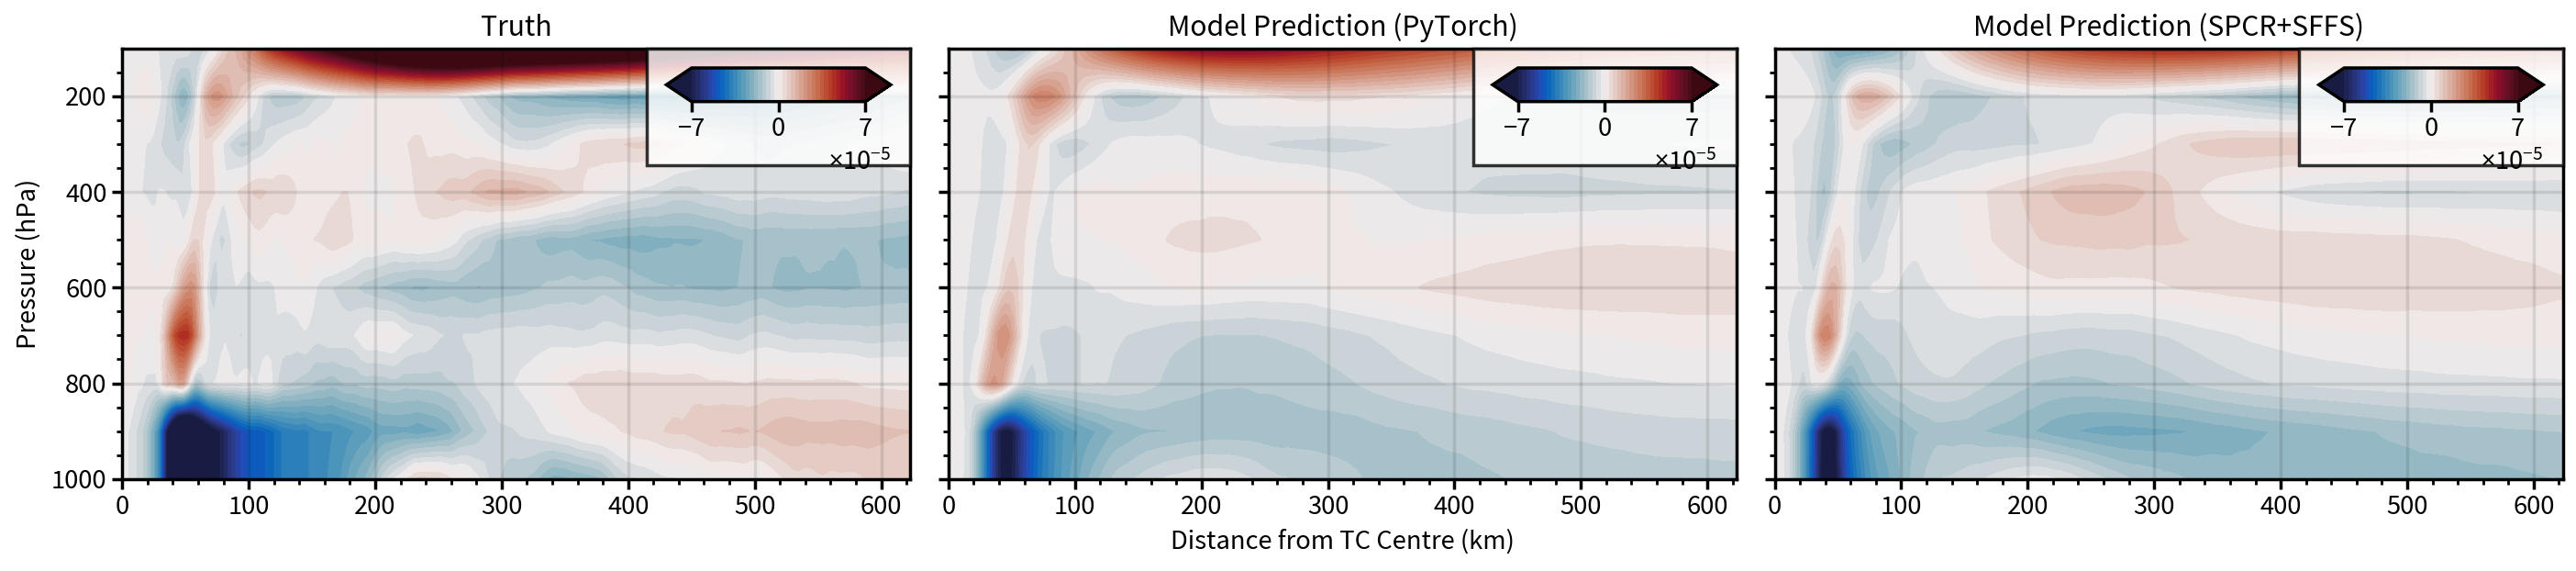

In [100]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['du'][40,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_u[40,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-5)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_u[40,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/du_prediction_train_all_60.png',dpi=300)
plt.show()

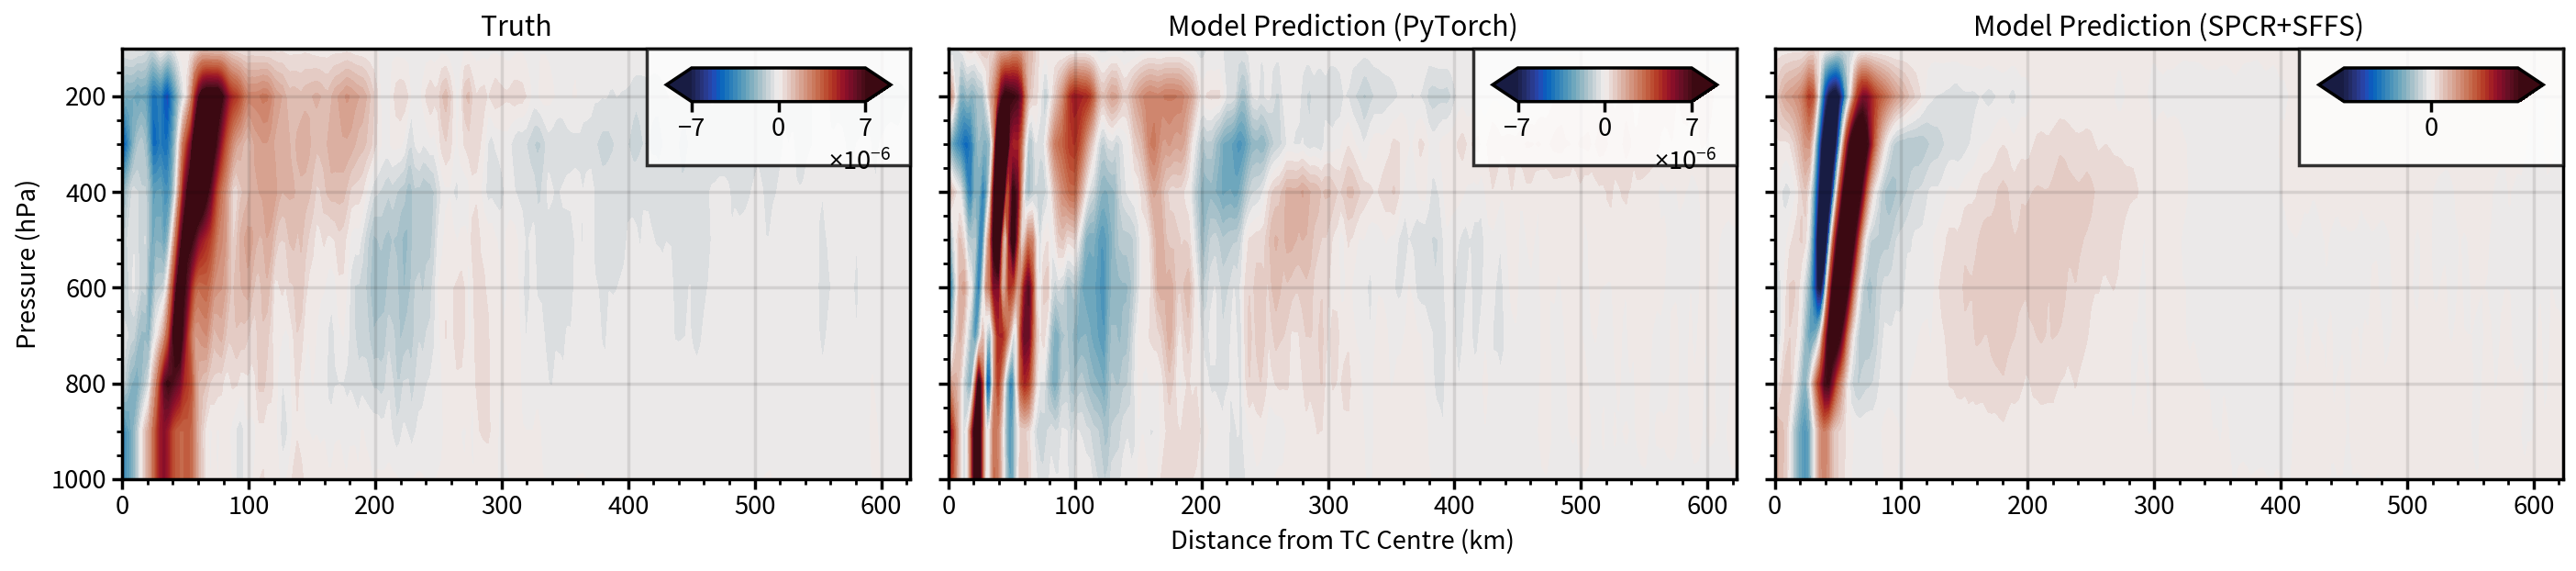

In [54]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dw'][70,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-6)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_w[70,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-6)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_w[70,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
plt.savefig('./pic/dw_prediction_train_lwswuw_withorig_70.png',dpi=300)
plt.show()

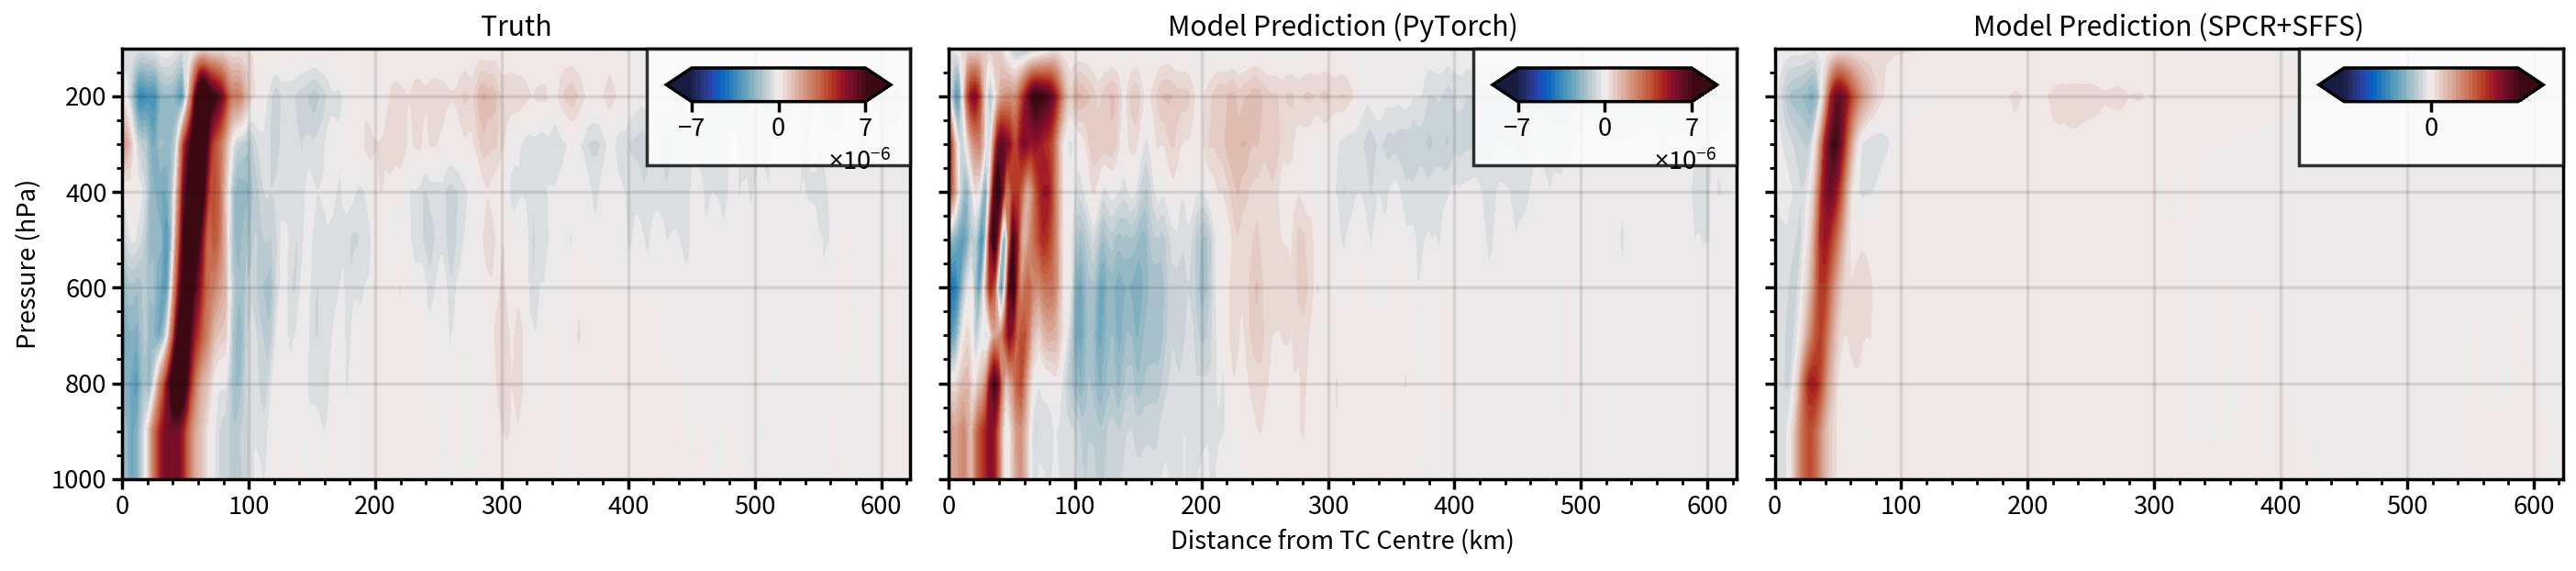

In [102]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dw'][78,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-6)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_w[80,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-6)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_w[80,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/dw_prediction_train_all_withorig_50.png',dpi=300)
plt.show()

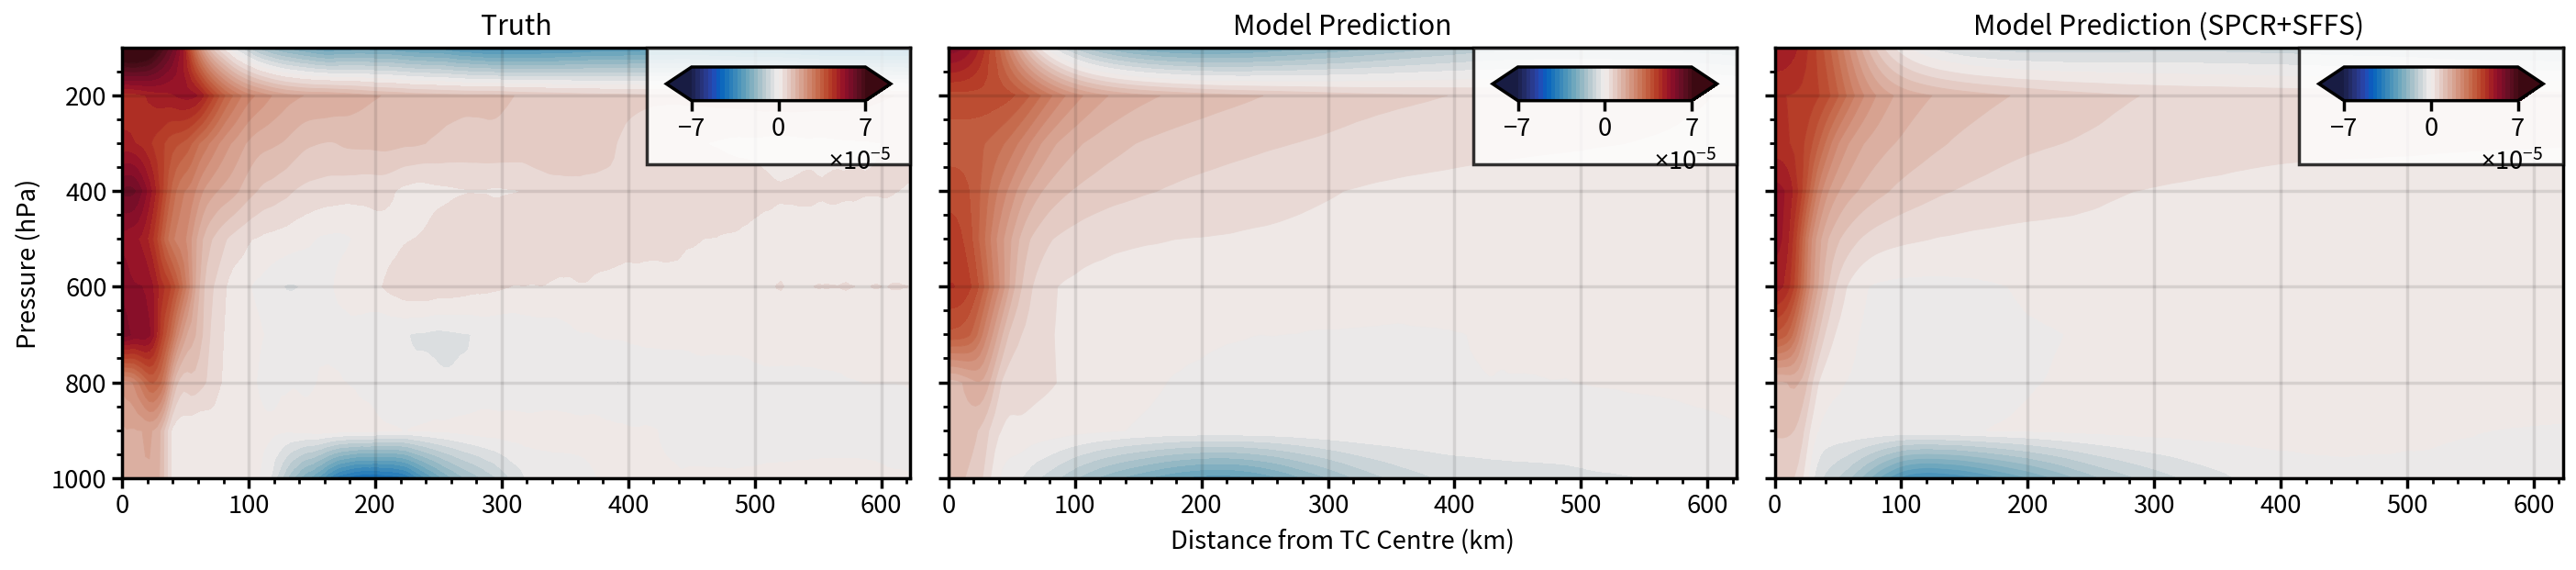

In [96]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dth'][20,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_th[20,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-5)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_th[20,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/dth_prediction_train_all_withorig_0.png',dpi=300)
plt.show()

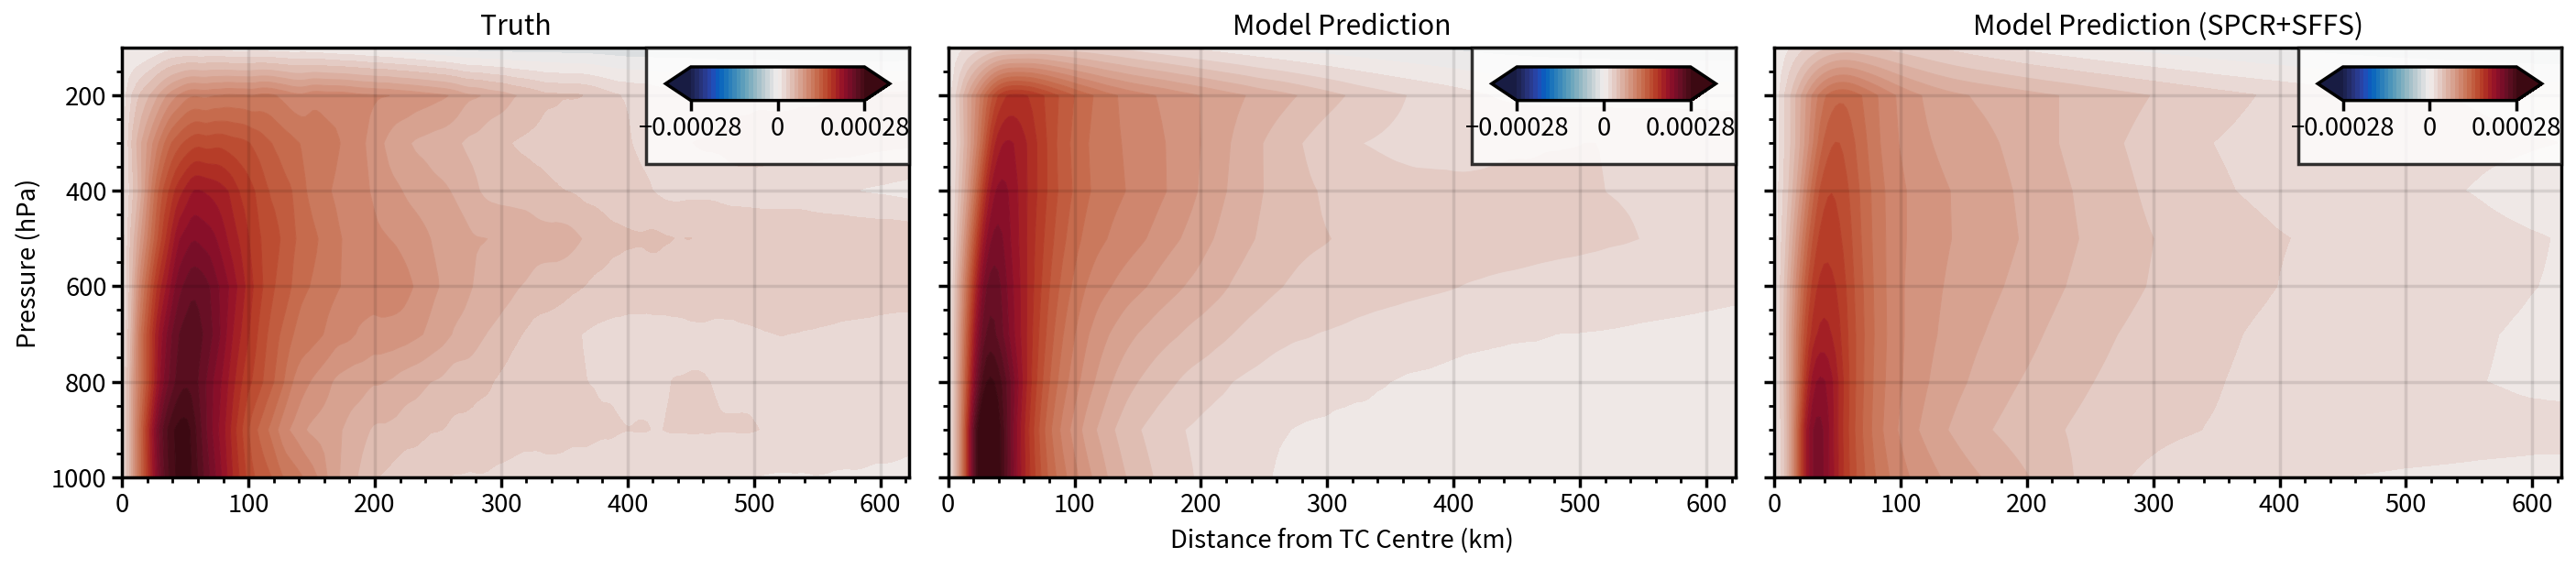

In [95]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dv'][0,...].reshape(10,208),cmap='balance',levels=np.linspace(-28e-5,28e-5,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=28e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_v[0,...].reshape(10,208),cmap='balance',levels=np.linspace(-28e-5,28e-5,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=28e-5)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_v[2,...].reshape(10,208),cmap='balance',levels=np.linspace(-28e-5,28e-5,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=28e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/dv_prediction_train_all_withorig_0.png',dpi=300)
plt.show()

### Optimal Structures

In [21]:
def flatten(l):
    return [item for sublist in l for item in sublist]
def normalize(array):
    return (array-np.nanmean(array))/np.nanstd(array)

allmodels_f = flatten(test_allmdls)
choosemodel = list(test_allpds['v2'].sort_values(by=['mean'], ascending=False).index)[0:5]
allmodels_f2 = [allmodels_f[objindx] for objindx in choosemodel]

allparams,allnames = [],[]
for i in range(len(allmodels_f2)):
    params,names = [],[]
    for name, param in allmodels_f2[i][0].named_parameters():
        if ".weight" not in name:
            continue
        else:
            params.append(param)
            names.append(name)
        #if (name=='dense8.weight') or (name=='dense7.weight'):
        #    params.append(param)
        #else:
        #    continue
    allparams.append(params)
    allnames.append(names)

In [22]:
optU = [np.squeeze(np.dot(allparam[0].data.numpy(),pcastore['lw'].components_[:52,:])).reshape(10,208) for allparam in allparams]
optV = [np.squeeze(np.dot(allparam[1].data.numpy(),pcastore['lw'].components_[:36,:])).reshape(10,208) for allparam in allparams]
optW = [np.squeeze(np.dot(allparam[2].data.numpy(),pcastore['lw'].components_[:60,:])).reshape(10,208) for allparam in allparams]
#optQV = [np.squeeze(np.dot(allparam[4].data.numpy(),pcastore['rh'].components_[:18,:])).reshape(10,208) for allparam in allparams]
optHDIA = [np.squeeze(np.dot(allparam[4].data.numpy(),pcastore['hdia'].components_[:18,:])).reshape(10,208) for allparam in allparams]
optLW = [np.squeeze(np.dot(allparam[5].data.numpy(),pcastore['lw'].components_[:30,:])).reshape(10,208) for allparam in allparams]
optSW = [np.squeeze(np.dot(allparam[6].data.numpy(),pcastore['sw'].components_[:30,:])).reshape(10,208) for allparam in allparams]

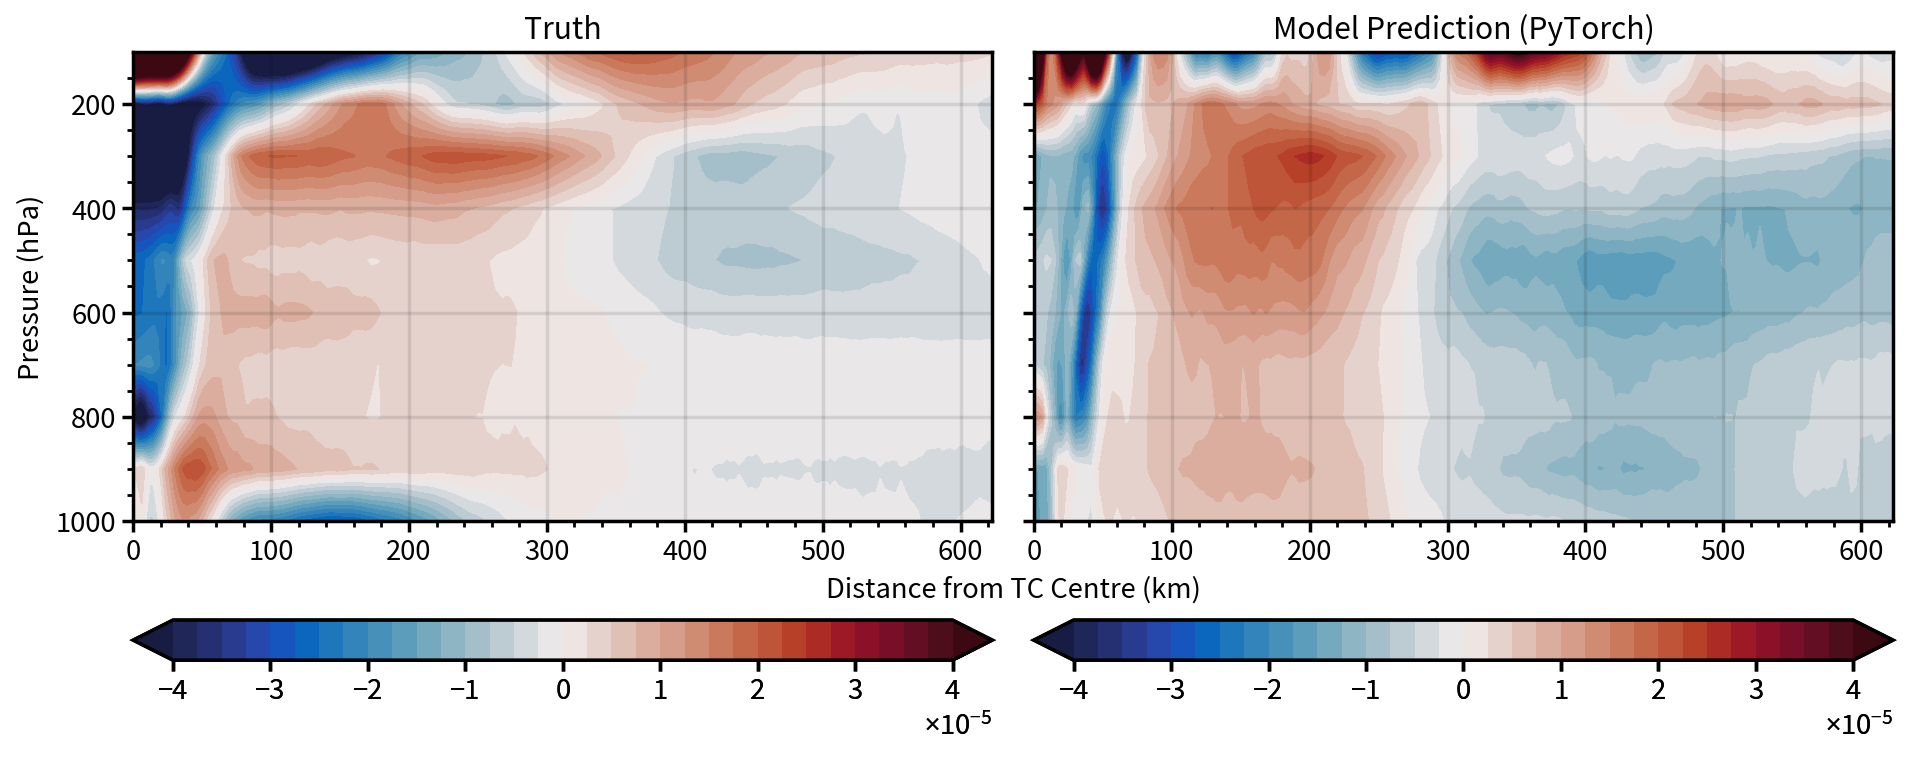

In [161]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),np.squeeze(np.dot(params[0].data.numpy(),pcastore['lw'].components_[:30,:])).reshape(10,208),levels=np.linspace(-0.4e-4,0.4e-4,33),cmap='balance',extend='both')
axs[0].colorbar(pcw,loc='bottom')#,ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),np.squeeze(np.dot(params[1].data.numpy(),pcastore['sw'].components_[:30,:])).reshape(10,208),levels=np.linspace(-0.4e-4,0.4e-4,33),cmap='balance',extend='both')
axs[1].colorbar(pcw,loc='bottom')
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')
#plt.savefig('./pic/du_prediction_train_all_60.png',dpi=300)
plt.show()

/tmp/ipykernel_2172698/90861964.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


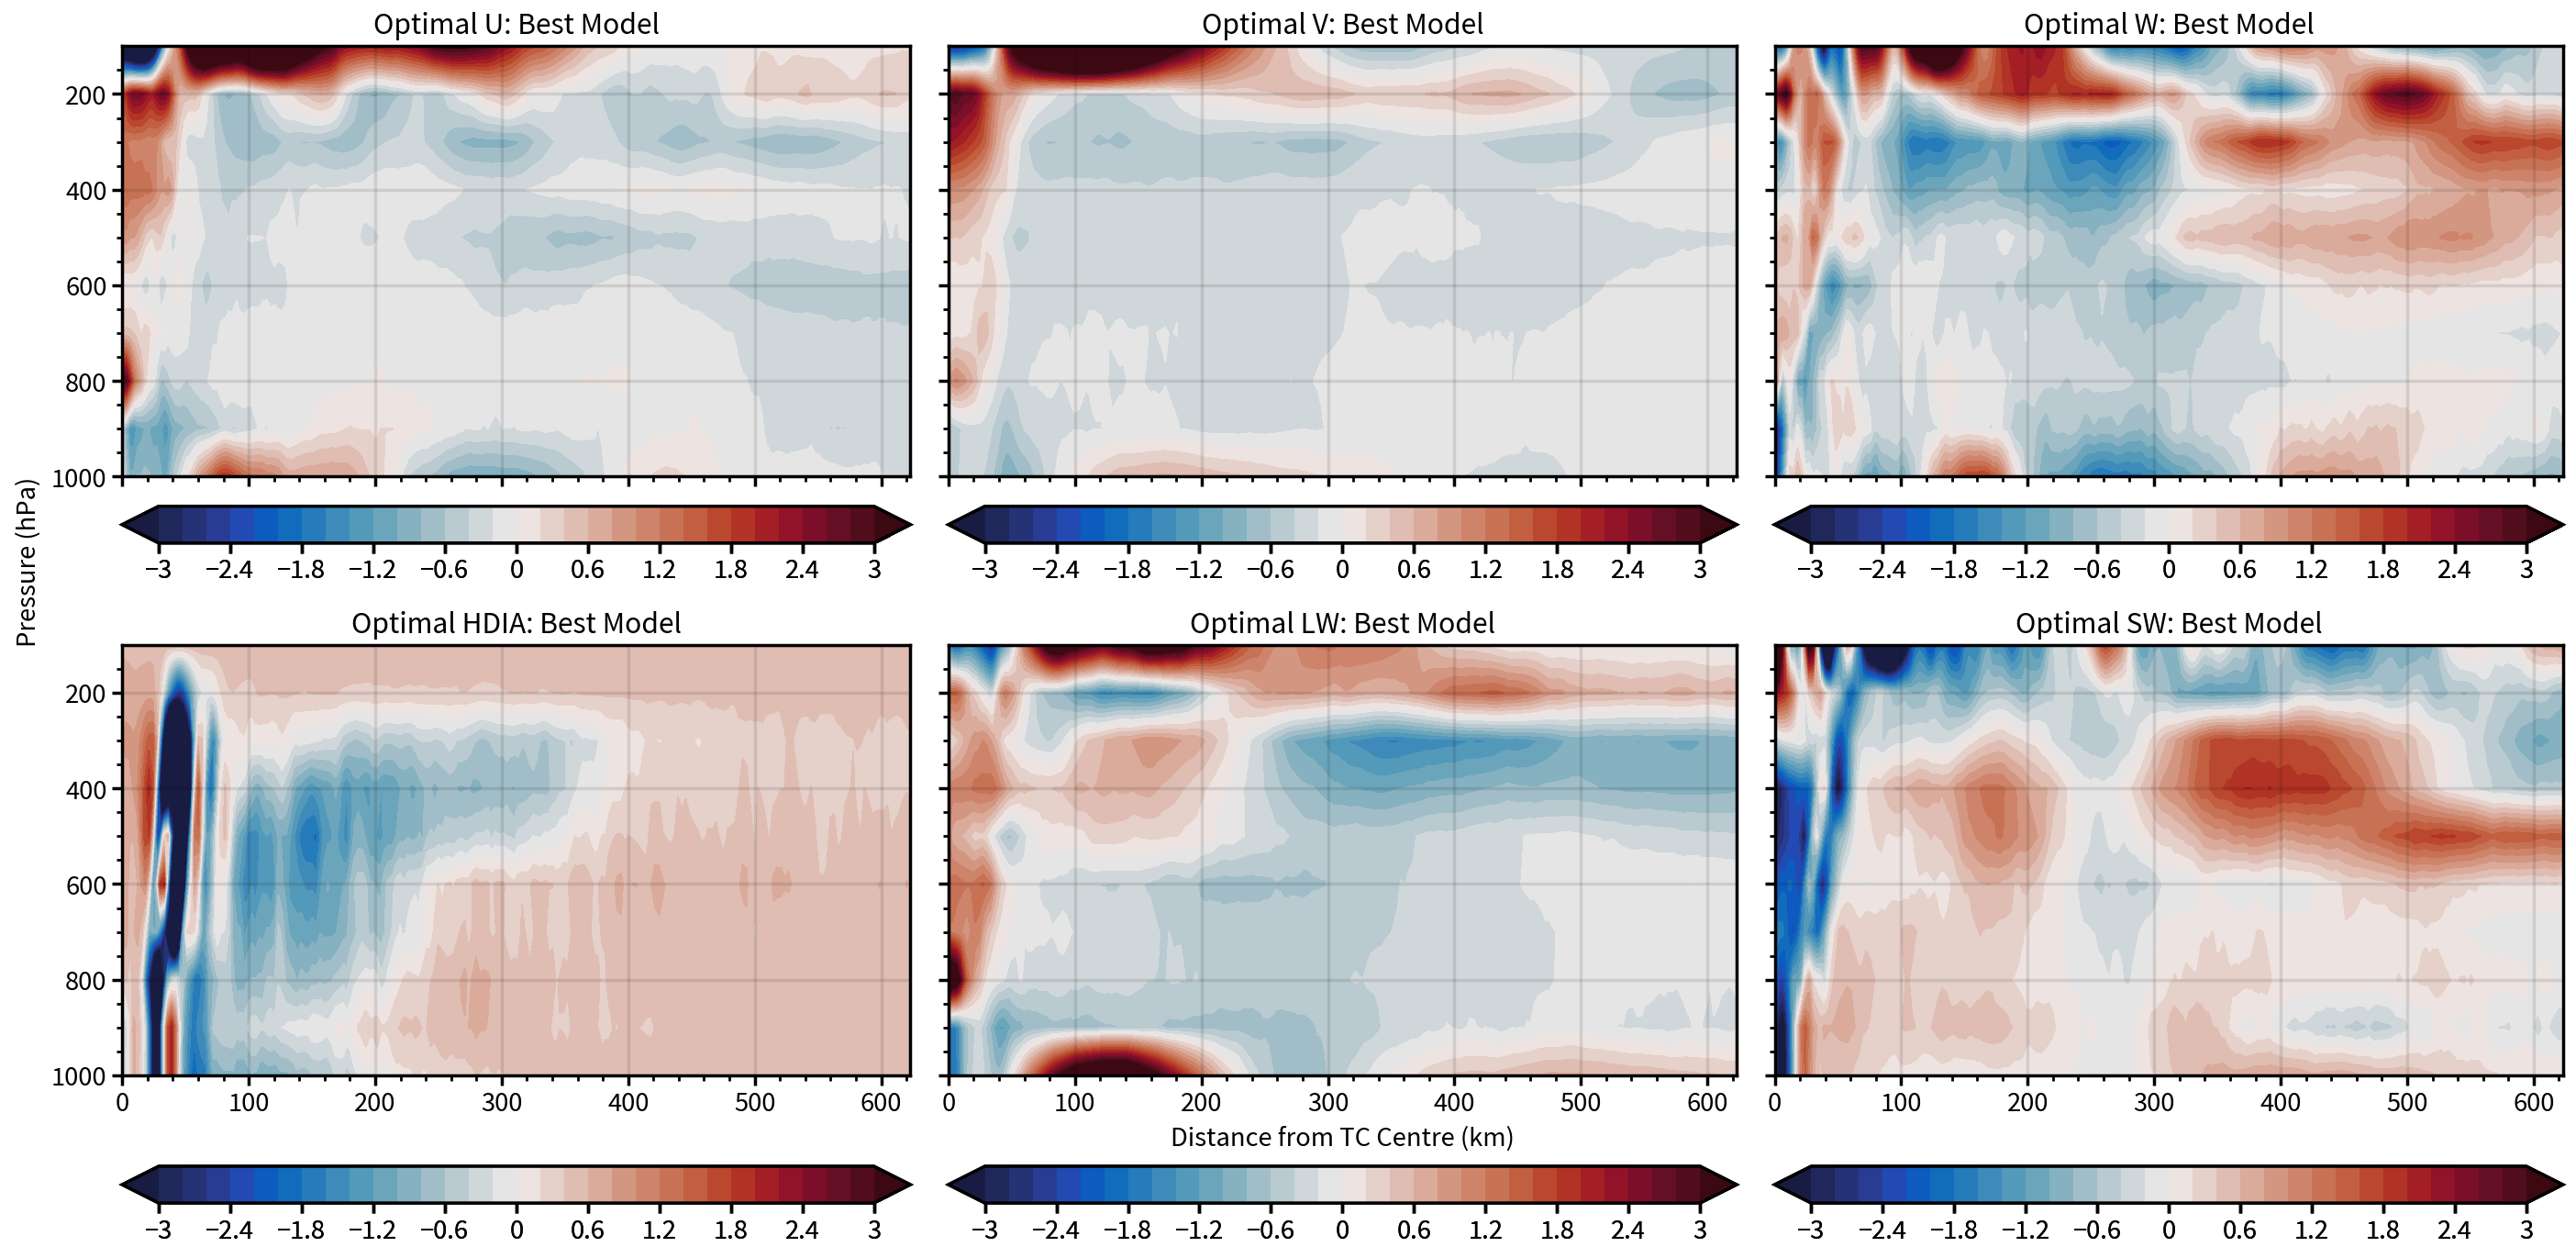

In [24]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

indx=1
fig,axs = plot.subplots(ncols=3,nrows=2,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optU[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[0].colorbar(pcw,loc='bottom')#,ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal U: Best Model')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optV[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[1].colorbar(pcw,loc='bottom')
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal V: Best Model')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optW[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[2].colorbar(pcw,loc='bottom')
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal W: Best Model')

pcw = axs[3].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optHDIA[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[3].colorbar(pcw,loc='bottom')
axs[3].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal HDIA: Best Model')

pcw = axs[4].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize(np.asarray(optLW[indx])),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[4].colorbar(pcw,loc='bottom')#,ticks=7e-5)
axs[4].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal LW: Best Model')

pcw = axs[5].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize(np.asarray(optSW[indx])),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[5].colorbar(pcw,loc='bottom')
axs[5].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal SW: Best Model')
plt.savefig('./pic/proposal/optimall.png',dpi=400)
plt.show()

In [37]:
! rm ./pic/1114/optim_structures_bestmodel1_weights.png

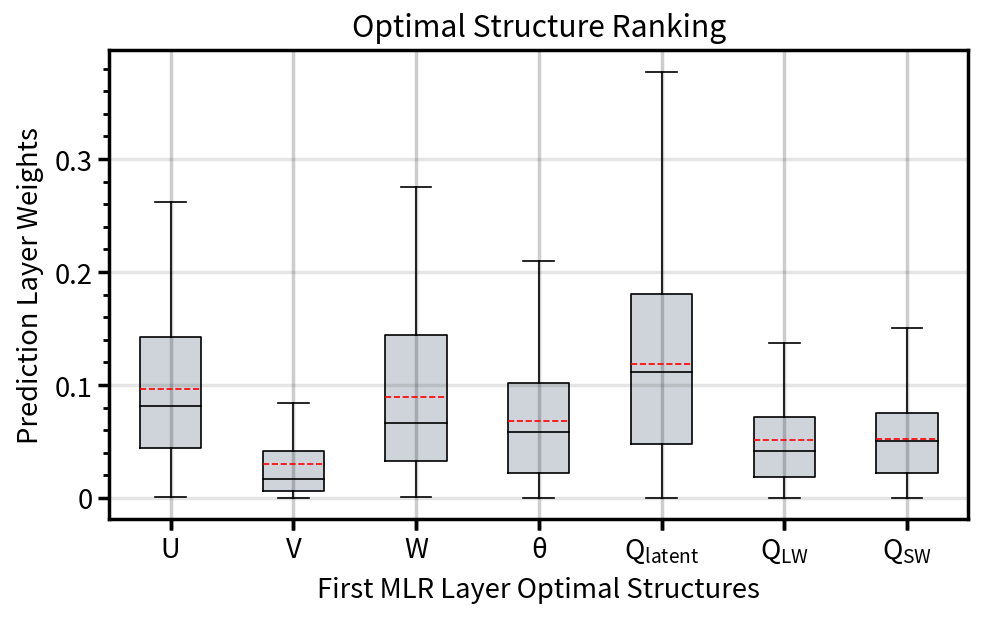

In [70]:
import seaborn as sns
indx=
ansss = [np.abs(allparams[indx][-1].data.numpy()[:,i]) for i in range(7)]
#anssss = [np.abs(weight*np.mean(xs)) for weight,xs in zip(ansss,[normalize(timeseries_u[0]),normalize(timeseries_v[0]),
#                                                                   normalize(timeseries_w[0]),normalize(timeseries_theta[0]),normalize(timeseries_hdia[0]),normalize(timeseries_lw[0]),normalize(timeseries_sw[0])])]
dataFI_haiyan = pd.DataFrame(np.asarray(ansss).transpose(),columns=['U','V','W',r'$\theta$',r'$Q_{latent}$',r'$Q_{LW}$',r'$Q_{SW}$'])

fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)#wspace=(0, 0, 0),height_ratios=[1.75, 1],sharey=0)
axs.boxplot(dataFI_haiyan, means=True, marker='x', meancolor='r', fillcolor='gray4', orientation='vertical',showfliers=False)
axs.format(ylabel=r'Prediction Layer Weights',xlabel='First MLR Layer Optimal Structures',title=r'Optimal Structure Ranking')#xlim=[0,0.0002*1.5e4])#ylim=[0,20])
plt.savefig('./pic/1114/optim_structures_bestmodel2_weights.png',dpi=400)
plt.show()
#pd.DataFrame(ansss).T.plot.box(ax=ax)

In [83]:
dataFI_haiyan.describe()

,U,V,W,$\theta$,$Q_{latent}$,$Q_{LW}$,$Q_{SW}$
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.125361,0.088183,0.083124,0.002521,0.057642,0.072895,0.045259
std,0.096465,0.070365,0.070609,0.006751,0.043090,0.060969,0.036791
min,0.000503,0.000079,0.000402,0.000036,0.001463,0.000460,0.000189
25%,0.042514,0.034271,0.024966,0.000454,0.019799,0.021408,0.012300
50%,0.105012,0.075146,0.058757,0.001130,0.049214,0.062135,0.035918
75%,0.196132,0.132056,0.133092,0.002123,0.088117,0.105543,0.075666
max,0.401897,0.418325,0.291857,0.062062,0.160786,0.271123,0.141838


In [25]:
def normalize_timeseries(timeseries=None):
    #assert timeseries['u'].shape[-1]==26,"var shape error"
    obj = (timeseries-np.nanmean(timeseries,axis=0))/np.nanstd(timeseries,axis=0)
    return obj

In [27]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
#folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
haiyan_data = read_and_proc.depickle(folderpath+'flatarrays2D.pkg')
timeseries_v = [np.dot(allparam[1].data.numpy(),normalize_timeseries(pcastore['v'].transform(haiyan_data['v'])[:,:36].T)) for allparam in allparams]
timeseries_u = [np.dot(allparam[0].data.numpy(),normalize_timeseries(pcastore['u'].transform(haiyan_data['u'])[:,:52].T)) for allparam in allparams]
timeseries_w = [np.dot(allparam[2].data.numpy(),normalize_timeseries(pcastore['w'].transform(haiyan_data['w'])[:,:60].T)) for allparam in allparams]
timeseries_theta = [np.dot(allparam[3].data.numpy(),normalize_timeseries(pcastore['theta'].transform(haiyan_data['theta'])[:,:28].T)) for allparam in allparams]
timeseries_lw = [np.dot(allparam[5].data.numpy(),normalize_timeseries(pcastore['lw'].transform(haiyan_data['lw'])[:,:30].T)) for allparam in allparams]
timeseries_sw = [np.dot(allparam[6].data.numpy(),normalize_timeseries(pcastore['sw'].transform(haiyan_data['sw'])[:,:30].T)) for allparam in allparams]
timeseries_hdia = [np.dot(allparam[4].data.numpy(),normalize_timeseries(pcastore['hdia'].transform(haiyan_data['hdia'])[:,:18].T)) for allparam in allparams]

In [28]:
def _back_to_exp(timeseries=None,divider=None):
    try:
        printout = [timeseries[0:divider[0],:]]
        for i in range(1,19):
            printout.append(timeseries[divider[i-1]:divider[i],:])
        printout.append(timeseries[divider[-2]:,:])
    except:
        printout = [timeseries[0:divider[0]]]
        for i in range(1,19):
            printout.append(timeseries[divider[i-1]:divider[i]])
        printout.append(timeseries[divider[-2]:])        
    return printout

In [29]:
indx=2
testlw,testsw,testhdia = _back_to_exp(np.squeeze(timeseries_lw[indx]),divider),_back_to_exp(np.squeeze(timeseries_sw[indx]),divider),_back_to_exp(np.squeeze(timeseries_hdia[indx]),divider)

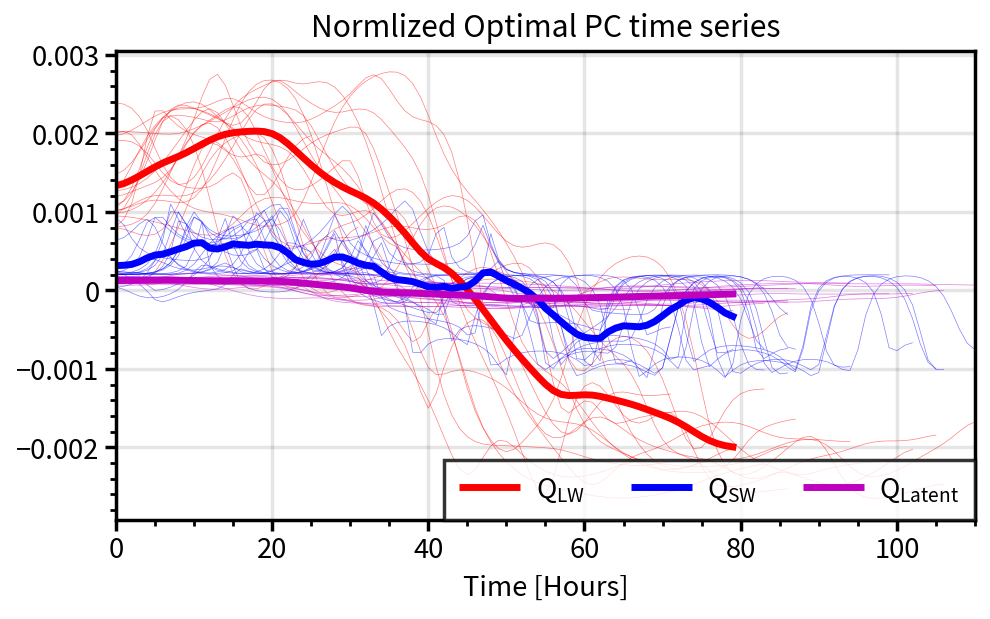

In [31]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for obj in testlw:
    axs.plot(obj,color='r',lw=0.25,alpha=0.5)
for obj in testsw:
    axs.plot(obj,color='b',lw=0.25,alpha=0.5)
for obj in testhdia:
    axs.plot(obj,color='m',lw=0.25,alpha=0.5)
axs.plot(np.mean(np.asarray([obj[:80] for obj in testlw if int(obj.shape[0])>80]),axis=0),color='r',lw=2.5,label=r'Q$_{LW}$')
axs.plot(np.mean(np.asarray([obj[:80] for obj in testsw if int(obj.shape[0])>80]),axis=0),color='b',lw=2.5,label=r'Q$_{SW}$')
axs.plot(np.mean(np.asarray([obj[:80] for obj in testhdia if int(obj.shape[0])>80]),axis=0),color='m',lw=2.5,label=r'Q$_{Latent}$')
axs.legend(loc='lr')
axs.format(xlabel='Time [Hours]',title='Normlized Optimal PC time series',)#ylim=[-0.0005,0.0005])
plt.savefig('./pic/proposal/optim_structures_bestmodel2_timeseries_divided.png',dpi=400)
plt.show()

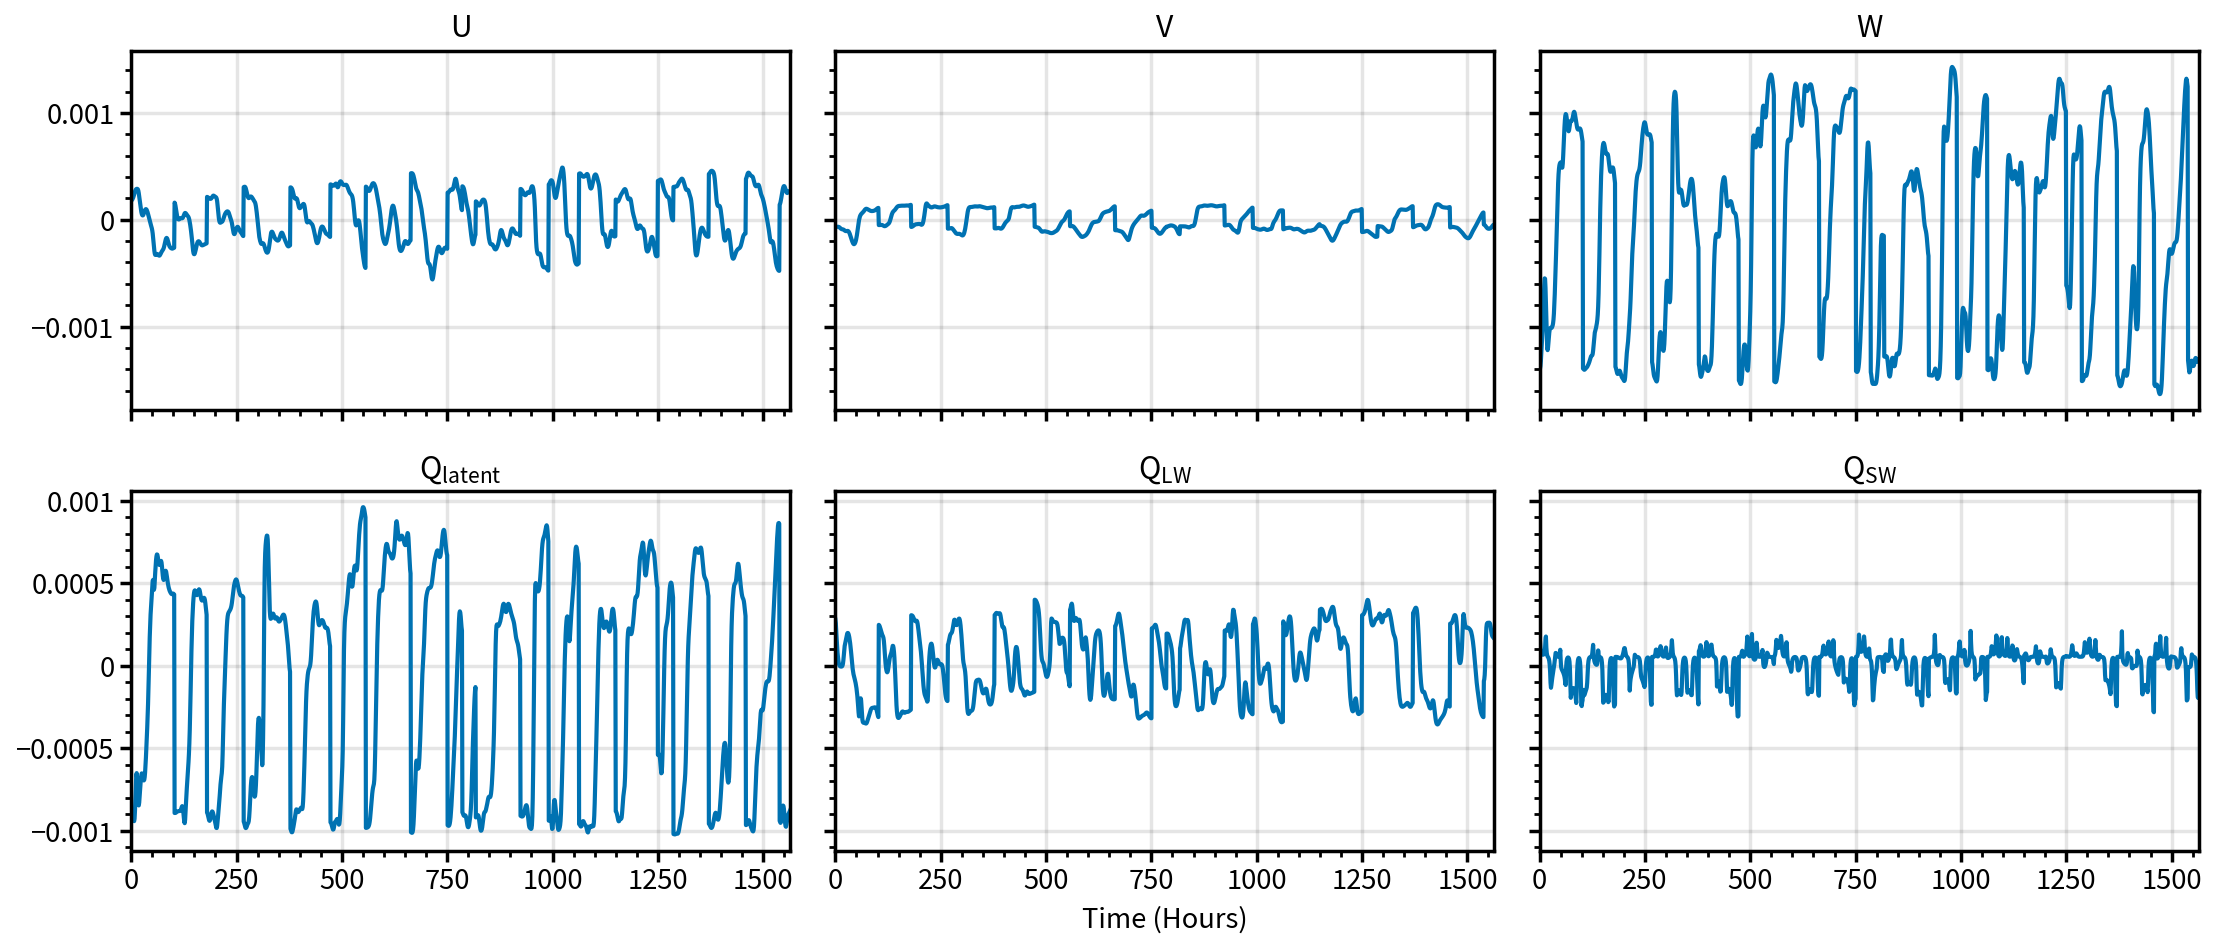

In [66]:
fig,axs = plot.subplots(ncols=3,nrows=2,axwidth=3.295,refaspect=1.831)
arrays = [(np.squeeze(timeseries_u[0])),(np.squeeze(timeseries_v[0])),(np.squeeze(timeseries_w[0])),(np.squeeze(timeseries_hdia[indx])),(np.squeeze(timeseries_lw[indx])),(np.squeeze(timeseries_sw[indx]))]
names = ['U','V','W',r'$Q_{latent}$',r'$Q_{LW}$',r'$Q_{SW}$']
for i in range(6):
    axs[i].plot(arrays[i])
    axs[i].format(title=names[i])
#axs[5].plot(normalize(np.squeeze(timeseries_hdia[0]))[0:1000])
axs.format(xlabel='Time (Hours)')
plt.savefig('./pic/1114/optim_structures_bestmodel3_timeseries.png',dpi=400)
plt.show()

In [121]:
folderpath = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
import pandas as pd
def _get_exp_name2(splitnum=None,folder=2,TYPE='varimax'):
    if TYPE=='varimax':
        return sorted(glob.glob(folderpath+'varimaxpca/X/random/Xtrain*'))[splitnum][:-7].split('/')[-1][6:],sorted(glob.glob(folderpath+'varimaxpca/X/random/Xtrain*'))[splitnum][:-7].split('/')[-1][6:].split('_')
    elif TYPE=='orig':
        return sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/Xtrain*'))[splitnum][:-7].split('/')[-1][6:],sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/Xtrain*'))[splitnum][:-7].split('/')[-1][6:].split('_')

def real_random(index=None,folder=2,TYPE='varimax'):
    toextract = _get_exp_name(index,folder,TYPE)[0]
    # X
    if TYPE=='varimax':
        Xtestpath,Xtrainpath,Xvalidpath = sorted(glob.glob(folderpath+'varimaxpca/X/random/*'+str(toextract)+'*'))
        yallpath = sorted(glob.glob(folderpath+'varimaxpca/y/random/*'+str(toextract)+'*'))
    elif TYPE=='orig':
        Xtestpath,Xtrainpath,Xvalidpath = sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/*'+str(toextract)+'*'))
        yallpath = sorted(glob.glob(folderpath+'pca/y/random/'+str(folder)+'/*'+str(toextract)+'*'))
    
    Xtest,Xtrain,Xvalid = [read_and_proc.depickle(obj) for obj in[Xtestpath,Xtrainpath,Xvalidpath]]
    yall = read_and_proc.depickle(yallpath[0])
    return Xtest,Xtrain,Xvalid,yall

def _where_exp_MLRpred(splitnum=None,divider=None,exp_index=None,LT=24):
    orig = np.r_[divider[0], np.diff(divider)]
    getindex = [int(obj) for obj in _get_exp_name2(splitnum,3,'varimax')[1]]
    if exp_index not in getindex:
        numexpout = sum([int(obj)<exp_index for obj in (getindex)])
        myindices = np.asarray([orig[i]-LT for i in range(len(orig)) if i not in getindex]).cumsum()
        return myindices[exp_index-numexpout-1],myindices[exp_index-numexpout],myindices[exp_index-numexpout]-myindices[exp_index-numexpout-1],'train'
    else:
        myidex = getindex.index(exp_index)
        if myidex<=1:
            category='valid'
            myindices = np.asarray([orig[i]-LT for i in range(len(orig)) if i in getindex[0:2]]).cumsum()
            if myidex==0:
                return 0,myindices[0],myindices[0],category
            elif myidex==1:
                return myindices[0],myindices[1],myindices[1]-myindices[0],category
        else:
            category='test'
            myindices = np.asarray([orig[i]-LT for i in range(len(orig)) if i in getindex[2:4]]).cumsum()
            if myidex==2:
                return 0,myindices[0],myindices[0],category
            elif myidex==3:
                return myindices[0],myindices[1],myindices[1]-myindices[0],category

def where_exp_MLRpred(expnum=10,LT=24):
    start,end,exp,size = [],[],[],[]
    for i in range(33):
        temp1,temp2,temp3,temp4 = _where_exp_MLRpred(i,divider,expnum,LT)
        start.append(temp1)
        end.append(temp2)
        exp.append(temp4)
        size.append(temp3)
        #except:
        #    start.append(None)
        #    end.append(None)
        #    exp.append(None)
        #    size.append(None)
    return pd.DataFrame.from_dict({'start':start,'end':end,'exp':exp,'size':size})

In [122]:
exp10dict,exp18dict = where_exp_MLRpred(expnum=10,LT=24), where_exp_MLRpred(expnum=12,LT=24)